In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wptfc24K1jabXxwja75u")
project = rf.workspace("a-kytup").project("viskom-gzhxz-vkdn0")
version = project.version(2)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Viskom-2 in coco:: 100%|██████████| 9548/9548 [00:02<00:00, 4392.99it/s]


In [2]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import json

# Ganti path ini sesuai lokasi file anotasi kamu
annotation_file = "/content/Viskom-2/train/_annotations.coco.json"

with open(annotation_file) as f:
    coco_json = json.load(f)

categories = coco_json.get('categories', [])

print("Daftar kelas di dataset:")
for cat in categories:
    print(f"ID: {cat['id']}, Nama kelas: {cat['name']}")


Daftar kelas di dataset:
ID: 0, Nama kelas: objects
ID: 1, Nama kelas: 1
ID: 2, Nama kelas: 2
ID: 3, Nama kelas: 3
ID: 4, Nama kelas: 4
ID: 5, Nama kelas: 5
ID: 6, Nama kelas: 6
ID: 7, Nama kelas: 7
ID: 8, Nama kelas: 8
ID: 9, Nama kelas: 9
ID: 10, Nama kelas: O
ID: 11, Nama kelas: addition
ID: 12, Nama kelas: division
ID: 13, Nama kelas: equal
ID: 14, Nama kelas: minus
ID: 15, Nama kelas: multiplication


In [4]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
import torchvision.transforms as T
from PIL import Image
import json
import os
import numpy as np

In [5]:
class CustomCocoDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms

        with open(annotation_file) as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

        self.img_id_to_annots = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_annots:
                self.img_id_to_annots[img_id] = []
            self.img_id_to_annots[img_id].append(ann)

        # Filter gambar dengan bbox
        self.valid_images = []
        for img in self.images:
            img_id = img['id']
            annots = self.img_id_to_annots.get(img_id, [])
            if len(annots) > 0:
                self.valid_images.append(img)

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_info = self.valid_images[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        annots = self.img_id_to_annots.get(img_id, [])

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in annots:
            bbox = ann['bbox']
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = x_min + bbox[2]
            y_max = y_min + bbox[3]

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])
            areas.append(bbox[2] * bbox[3])
            iscrowd.append(ann.get('iscrowd', 0))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


In [6]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)


def get_model(num_classes):
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)

    # Ambil in_channels dari module_list lama
    old_head = model.head.classification_head
    module_list = old_head.module_list

    in_channels = []
    for seq in module_list:
        conv2d_norm_act = seq[0]
        conv2d_layer = conv2d_norm_act[0]
        in_channels.append(conv2d_layer.in_channels)

    num_anchors = [6] * len(in_channels)

    model.head.classification_head = SSDLiteClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=nn.BatchNorm2d
    )
    return model


In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
train_dataset = CustomCocoDataset(
    root="/content/Viskom-2/train",
    annotation_file="/content/Viskom-2/train/_annotations.coco.json",
    transforms=get_transform(train=True)
)
val_dataset = CustomCocoDataset(
    root="/content/Viskom-2/valid",
    annotation_file="/content/Viskom-2/valid/_annotations.coco.json",
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [9]:
num_classes = 1 + max(ann['category_id'] for ann in train_dataset.annotations)

model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 65.1MB/s]


In [10]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
    return total_loss / len(data_loader)


def evaluate_loss(model, data_loader, device):
    model.train()  # tetap train mode supaya bisa hitung loss
    total_loss = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(data_loader)

In [12]:
num_epochs = 30
best_val_loss = float('inf')
patience = 5   # jumlah epoch tanpa perbaikan sebelum berhenti
counter = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate_loss(model, val_loader, device)
    lr_scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_ssdlite_mobilenetv3.pth')
        print("Checkpoint saved.")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s).")

    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Epoch 1, Train Loss: 1.8813, Val Loss: 2.8553
Checkpoint saved.
Epoch 2, Train Loss: 1.8406, Val Loss: 2.7594
Checkpoint saved.
Epoch 3, Train Loss: 1.6062, Val Loss: 2.6340
Checkpoint saved.
Epoch 4, Train Loss: 1.4405, Val Loss: 2.6237
Checkpoint saved.
Epoch 5, Train Loss: 1.3067, Val Loss: 2.4443
Checkpoint saved.
Epoch 6, Train Loss: 1.1983, Val Loss: 2.5021
No improvement for 1 epoch(s).
Epoch 7, Train Loss: 1.1016, Val Loss: 2.5288
No improvement for 2 epoch(s).
Epoch 8, Train Loss: 1.0302, Val Loss: 2.4777
No improvement for 3 epoch(s).
Epoch 9, Train Loss: 0.9595, Val Loss: 2.4437
Checkpoint saved.
Epoch 10, Train Loss: 0.8959, Val Loss: 2.5414
No improvement for 1 epoch(s).
Epoch 11, Train Loss: 0.8473, Val Loss: 2.5598
No improvement for 2 epoch(s).
Epoch 12, Train Loss: 0.8050, Val Loss: 2.4719
No improvement for 3 epoch(s).
Epoch 13, Train Loss: 0.7636, Val Loss: 2.5437
No improvement for 4 epoch(s).
Epoch 14, Train Loss: 0.7152, Val Loss: 2.5228
No improvement for 5 epoch

In [13]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.0 MB/s eta 0:00:00


In [34]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate_map_iou(model, data_loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type='bbox').to(device)

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            metric.update(outputs, targets)

    results = metric.compute()

    print(f"mAP (IoU=0.5:0.95): {results['map'].item():.4f}")
    print(f"mAP@0.5: {results['map_50'].item():.4f}")
    print(f"mAP@0.75: {results['map_75'].item():.4f}")
    print(f"Average IoU: {results['map_iou'].item() if 'map_iou' in results else 'N/A'}")

    return results


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

model.load_state_dict(torch.load('best_ssdlite_mobilenetv3.pth'))
model.to(device)

import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

def get_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
    return iou

def evaluate_full_metrics(model, data_loader, device, class_names, iou_thresh=0.5, score_thresh=0.5):
    model.eval()

    # Untuk mAP dan IoU dari torchmetrics
    map_metric = MeanAveragePrecision(iou_type='bbox').to(device)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            # Update mAP metric
            map_metric.update(outputs, targets)

            for output, target in zip(outputs, targets):
                true_boxes = target['boxes'].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()

                # Filter prediksi dengan threshold skor
                keep = pred_scores >= score_thresh
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                matched_gt = set()
                matched_pred = set()

                # Cocokkan prediksi ke GT berdasarkan IoU dan label
                for i, (tbox, tlabel) in enumerate(zip(true_boxes, true_labels)):
                    best_iou = 0
                    best_j = -1
                    for j, (pbox, plabel) in enumerate(zip(pred_boxes, pred_labels)):
                        if j in matched_pred:
                            continue
                        if tlabel != plabel:
                            continue
                        iou = get_iou(tbox, pbox)
                        if iou > best_iou:
                            best_iou = iou
                            best_j = j
                    if best_iou >= iou_thresh:
                        matched_gt.add(i)
                        matched_pred.add(best_j)
                        y_true.append(tlabel)
                        y_pred.append(pred_labels[best_j])
                    else:
                        # GT tanpa prediksi: False Negative
                        y_true.append(tlabel)
                        y_pred.append(0)  # 0 untuk background / no detection

                # Prediksi yang tidak match: False Positive
                for j, plabel in enumerate(pred_labels):
                    if j not in matched_pred:
                        y_true.append(0)
                        y_pred.append(plabel)

    # Compute mAP dan IoU
    map_results = map_metric.compute()

    # Compute confusion matrix dan classification metrics
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(len(class_names))))

    # Visualisasi confusion matrix
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Cetak hasil metrics klasifikasi per kelas
    for i, cls in enumerate(class_names):
        print(f"Class {cls}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={f1[i]:.3f}")

    print(f"\nOverall mAP (IoU=0.5:0.95): {map_results['map'].item():.4f}")
    print(f"mAP@0.5: {map_results['map_50'].item():.4f}")
    print(f"mAP@0.75: {map_results['map_75'].item():.4f}")

    return {
        'mAP': map_results['map'].item(),
        'mAP_50': map_results['map_50'].item(),
        'mAP_75': map_results['map_75'].item(),
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }



Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.


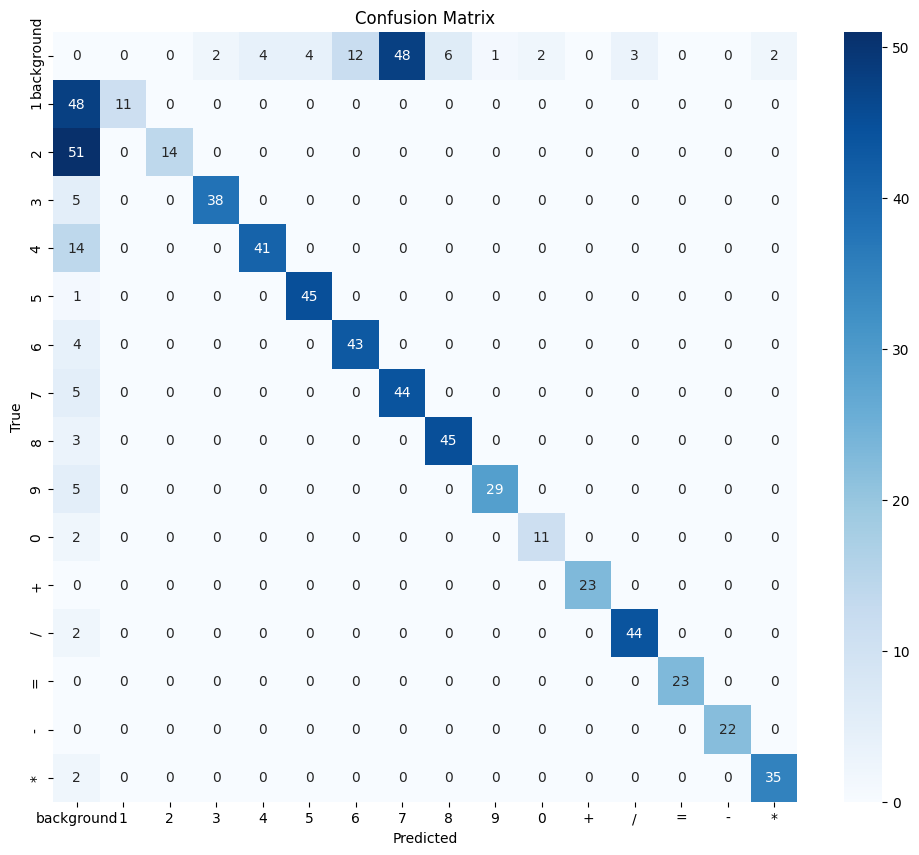

Class background: Precision=0.000, Recall=0.000, F1-score=0.000
Class 1: Precision=1.000, Recall=0.186, F1-score=0.314
Class 2: Precision=1.000, Recall=0.215, F1-score=0.354
Class 3: Precision=0.950, Recall=0.884, F1-score=0.916
Class 4: Precision=0.911, Recall=0.745, F1-score=0.820
Class 5: Precision=0.918, Recall=0.978, F1-score=0.947
Class 6: Precision=0.782, Recall=0.915, F1-score=0.843
Class 7: Precision=0.478, Recall=0.898, F1-score=0.624
Class 8: Precision=0.882, Recall=0.938, F1-score=0.909
Class 9: Precision=0.967, Recall=0.853, F1-score=0.906
Class 0: Precision=0.846, Recall=0.846, F1-score=0.846
Class +: Precision=1.000, Recall=1.000, F1-score=1.000
Class /: Precision=0.936, Recall=0.957, F1-score=0.946
Class =: Precision=1.000, Recall=1.000, F1-score=1.000
Class -: Precision=1.000, Recall=1.000, F1-score=1.000
Class *: Precision=0.946, Recall=0.946, F1-score=0.946

Overall mAP (IoU=0.5:0.95): 0.6358
mAP@0.5: 0.8769
mAP@0.75: 0.7761


In [36]:
class_names = ['background', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '+', '/', '=', '-', '*']
metrics = evaluate_full_metrics(model, val_loader, device, class_names, iou_thresh=0.5, score_thresh=0.5)


In [21]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def infer_and_visualize(model, image_path, class_names, device, threshold=0.5):
    model.eval()
    transform = T.Compose([T.ToTensor()])

    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).to(device)

    with torch.no_grad():
        outputs = model([img_tensor])

    output = outputs[0]
    boxes = output['boxes'].cpu()
    scores = output['scores'].cpu()
    labels = output['labels'].cpu()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        if score < threshold:
            continue
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x_min, y_min,
            f"{class_names[label]}: {score:.2f}",
            bbox=dict(facecolor='yellow', alpha=0.5),
            fontsize=12,
            color='black'
        )

    plt.axis('off')
    plt.show()


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('best_ssdlite_mobilenetv3.pth'))
model.to(device)
class_names = ['background', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '/', '=', '-', '*']

Processing WIN_20250513_16_05_17_Pro_mp4-0030_jpg.rf.7e10ae61452d86abadbe6ba12b4087e0.jpg ...


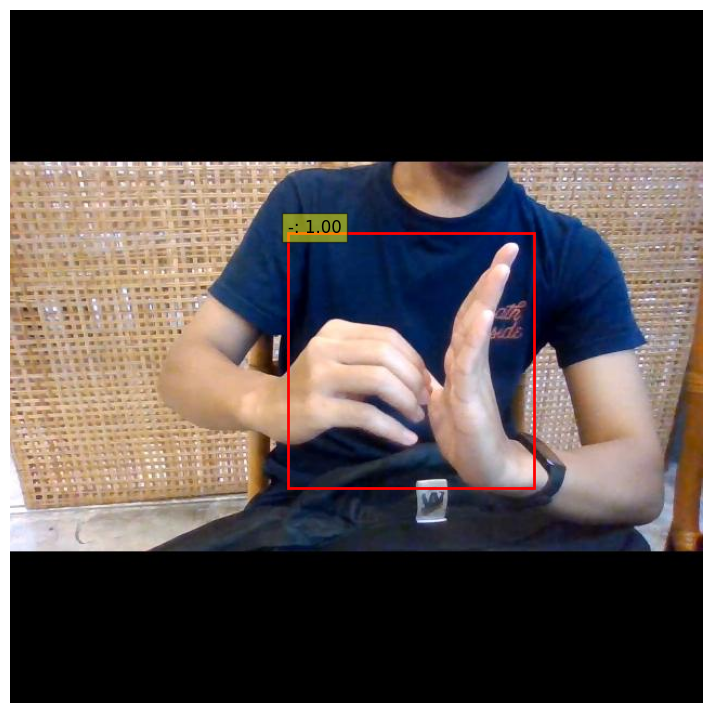

Processing VID_20250511_195750_mp4-0026_jpg.rf.ed81bb3b3844c5ce83c841f03457247d.jpg ...


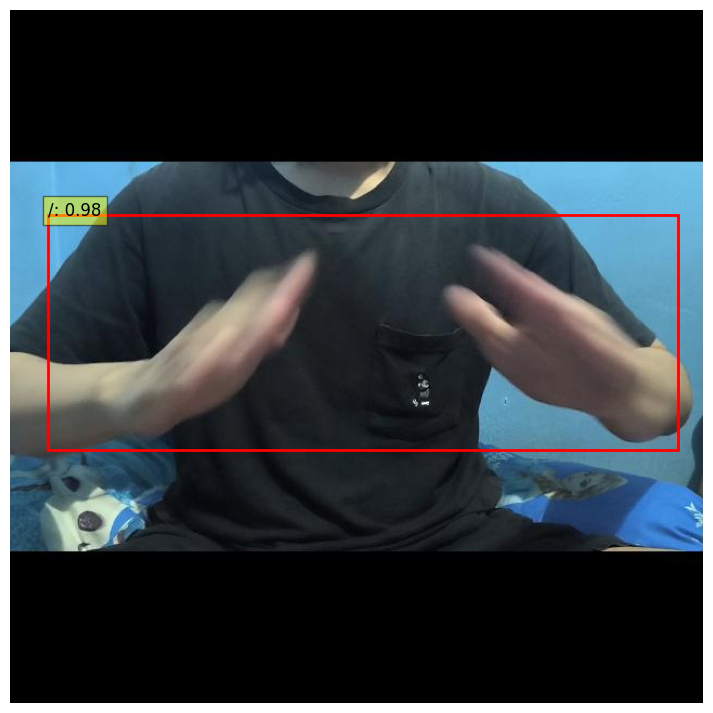

Processing WIN_20250513_15_39_09_Pro_mp4-0001_jpg.rf.866d0b665b0d5c9bd5881d2c63b99115.jpg ...


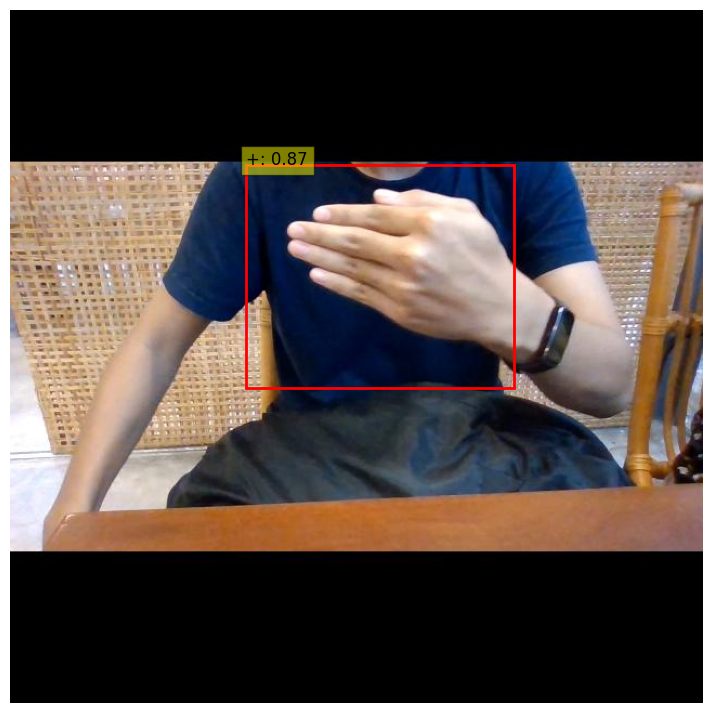

Processing Learn-How-to-Sign-Numbers-in-ASL-_-K-L-Sign-Time_mp4-0027_jpg.rf.c55f50399320233621b26aefb96ddd1c.jpg ...


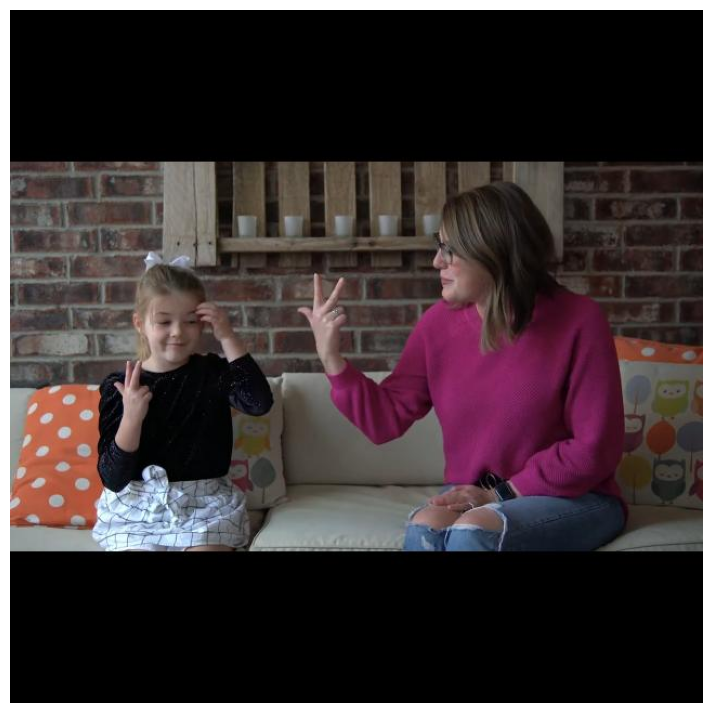

Processing IMG_5345_MOV-0003_jpg.rf.df66ea2cf31ae37303f0137016492c23.jpg ...


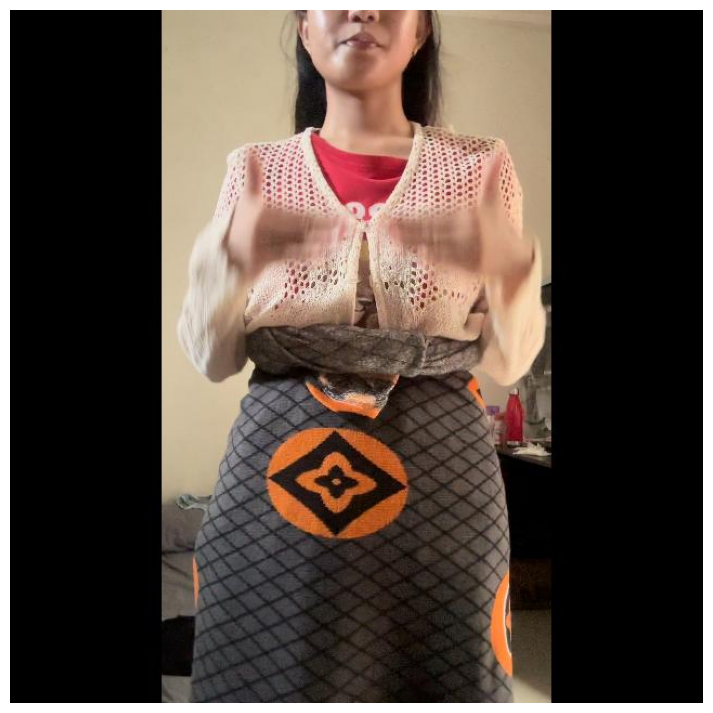

In [23]:
import os

test_folder = "/content/Viskom-2/test"
count = 0
max_images = 5

for filename in os.listdir(test_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(test_folder, filename)
        print(f"Processing {filename} ...")
        infer_and_visualize(model, image_path, class_names, device, threshold=0.5)

        count += 1
        if count >= max_images:
            break